# VLSI - CP Part
Di Tuccio Gianluca, Orsini Lorenzo

In [1]:
from minizinc import Instance, Model, Solver
from datetime import timedelta
import time
import pandas as pd
import os
from tqdm import tqdm
random_seed = 42

'''
SET HERE THE PATH OF THE MAIN FOLDER (i.e VLSI folder)
            |
            |
            V
'''
os.chdir('/Users/gianlucadituccio/Documents/VLSI')
from utils.utils import *

In [ ]:
async def solve_model(model_path, solver, parameters, timeout, rotation=False):
    
    # load the model
    model = Model(model_path)
    solver = Solver.lookup(solver)
    instance = Instance(solver, model)

    # sort rectangles by y components (if they are equal, then compare x components)
    # store the indeces of the rectangles before sorting them
    x_max = max(parameters['x_components'])
    y_max = max(parameters['y_components'])
    rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
    
    # if there exists a rectangle with a x component higher than any y component and rotation is enabled,
    # then rotate the rectangle and sort the others. At the end, insert the rotated block in the top of the list
    if rotation and x_max>y_max and x_max<=height:
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[0],x[1]), reverse=True)
        instance['first_rectangle_rot'] = True
        first_rectangle = sorted_rectangles[0]
        sorted_rectangles = sorted(rectangles[1:], key=lambda x: (x[1],x[0]), reverse=True)
        sorted_rectangles.insert(0, first_rectangle)
    
    # if rotation is enabled and there aren't x components higher then any y component, then simply sort
    elif rotation:
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        instance['first_rectangle_rot'] = False
    
    # sort the rectangles by y component
    else: sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
    x_components = [k[0] for k in sorted_rectangles]
    y_components = [k[1] for k in sorted_rectangles]
    original_indices = [k[2] for k in sorted_rectangles]
    
    # assign the parameters to the model
    instance['w'] = parameters['w']
    instance['n'] = parameters['n_rectangles']
    instance['x_components']=x_components
    instance['y_components']=y_components
    instance['min_h']=parameters['min_h']
    
    # create the output variable for storing the results
    output = {}
    
    # change the name of the variables if the model has the rotation enabled
    try:
        # solve the problem
        t1 = time.time()
        result = await instance.solve_async(timeout=timedelta(seconds=timeout), random_seed=random_seed, processes=8, free_search=True)
        t2 = time.time()
        
        if rotation:
            # restore the order before the sort by y components
            positions = [(x, y, i, z, k) for x, y, i, z, k in zip(result['x_positions'], 
                                                            result['y_positions'], 
                                                            result['x_components_rot'], 
                                                            result['y_components_rot'],
                                                            original_indices)]
        
        else:
            positions = [(x, y, i, z, k) for x, y, i, z, k in zip(result['x_positions'], 
                                                            result['y_positions'], 
                                                            x_components, 
                                                            y_components,
                                                            original_indices)]
        # store the results
        sorted_positions = sorted(positions, key=lambda x: x[4])
        output['x_positions'], output['y_positions'], output['x_components'], output['y_components'], _ = zip(*sorted_positions)
            
        # save h found, initial W and the computational time
        output['h'] = result['h']
        output['W'] = parameters['w']
        output['time'] = t2-t1
        output['h_min'] = parameters['min_h']
    
    except Exception as ex: print(ex)
    
    finally: return output

## Test CP
Here, you can find the code for testing the different models.

In [ ]:
rotation = True # True --> enable rotation
model_name = 'VLSI.mzn' if not rotation else 'VLSI_rotation.mzn'
solver = 'chuffed'

for i in tqdm(range(1,41)):
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')
    result = await solve_model(model_path='CP/src/'+model_name, solver=solver, 
                               parameters=file, timeout=300, rotation=rotation)
    if result:
        # if you want plot the results without saving them, use: PlotInstance(result)
        PlotInstance(result, 
                     path='CP/images', 
                     name='fig-'+str(i) if not rotation else 'rotation_fig-'+str(i))
        WriteInstance(result,
                     path='CP/out',
                     name='out-'+str(i) if not rotation else 'rotation_out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')

## Gecode VS Chuffed
For the CP part, we've tried different strategies and models. All the results has been stored in the ***datasets*** folder, inside the ***utils*** folder.<br>
First, we've compared Chuffed and Gecode, as shown below:

In [2]:
models = pd.read_csv('utils/datasets/gecode_chuffed.csv')
Statistics({'Gecode':models['time_gecode'], 'Chuffed':models['time_chuffed']}, 
           {'h_min':models['h_min'], 'Gecode':models['h_gecode'], 'Chuffed':models['h_chuffed']},
           timeout=300)

TIMEOUT is seen as 300s.

+------------------+----------+----------+
|                  |   Gecode |  Chuffed |
+------------------+----------+----------+
|  Total Time [s]  | 7804.766 | 3389.981 |
|     Max [s]      |    300.0 |    300.0 |
|     Min [s]      |    0.316 |    0.163 |
|     Mean [s]     |  195.119 |    84.75 |
|     Std [s]      |  144.749 |  130.403 |
| Instances Solved |    14/40 |    30/40 |
|    Optimal H     |    14/40 |    30/40 |
+------------------+----------+----------+


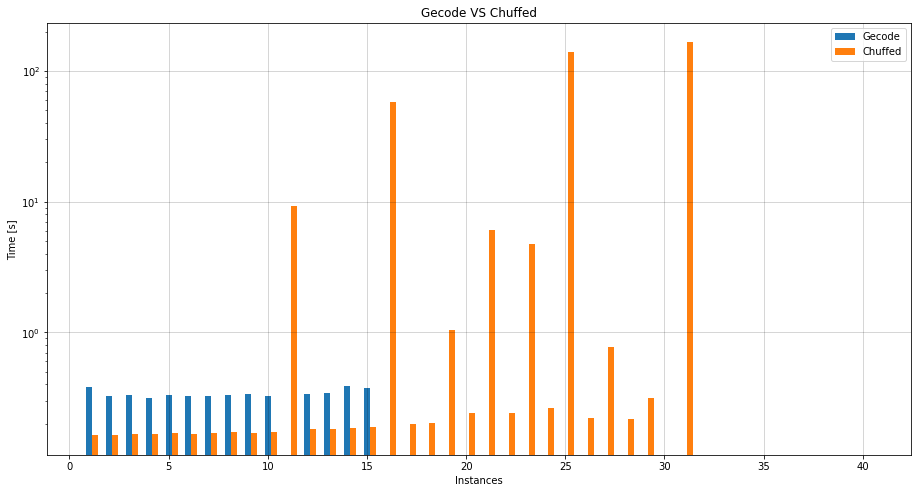

In [3]:
PlotStats({'Gecode':models['time_gecode'], 'Chuffed':models['time_chuffed']}, x_axis=list(models['Instance']))

## Chuffed Ordered VS Chuffed Free Search
After selecting the most suitable model (i.e. Chuffed), we attempted various strategies: one of which utilized the input order of rectangles (all rectangles were ordered by their y-components), and the other strategy employed the use of free search from the Python API.

In [4]:
strategies = pd.read_csv('utils/datasets/chuffed_strategies.csv')
Statistics({'Chuffed Ordered':strategies['time_chuffed'], 
            'Chuffed Free Search':strategies['time']}, 
           {'h_min':strategies['h_min'], 
            'Chuffed Ordered':strategies['h_chuffed'], 
            'Chuffed Free Search':strategies['h']},
           timeout=300)

TIMEOUT is seen as 300s.

+------------------+-----------------+---------------------+
|                  | Chuffed Ordered | Chuffed Free Search |
+------------------+-----------------+---------------------+
|  Total Time [s]  |        3389.981 |             594.318 |
|     Max [s]      |           300.0 |               300.0 |
|     Min [s]      |           0.163 |               0.157 |
|     Mean [s]     |           84.75 |              14.858 |
|     Std [s]      |         130.403 |              54.793 |
| Instances Solved |           30/40 |               39/40 |
|    Optimal H     |           30/40 |               39/40 |
+------------------+-----------------+---------------------+


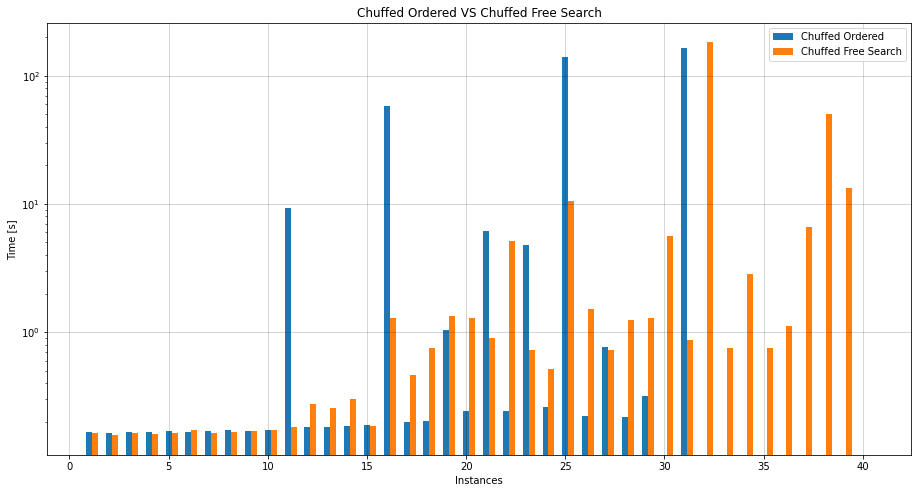

In [5]:
PlotStats({'Chuffed Ordered':strategies['time_chuffed'], 
           'Chuffed Free Search':strategies['time']}, x_axis=list(models['Instance']))

## Chuffed VS Heuristics
At the end, we've evaluate the free search model with different heuristics, in particular the seq_search with restart of 100, 5000 and without restart, and adding the search on x and y coordinates with first fail.<br>
The best model was the one with a constant restart of 5000, which computes all the 40 instances.

In [6]:
heuristics = pd.read_csv('utils/datasets/chuffed_heuristcs.csv')
Statistics({'FS':heuristics['time'], 
            'FS + Restart 5000':heuristics['time_restart5000'],
            'FS + Restart 100':heuristics['time_restart100'],
            'First Fail':heuristics['time_fail']}, 
           {'h_min':heuristics['h_min'], 
            'FS':heuristics['h'], 
            'FS + Restart 5000':heuristics['h_restart5000'],
            'FS + Restart 100':heuristics['h_restart100'],
            'First Fail': heuristics['h_fail']},
            timeout=300)

TIMEOUT is seen as 300s.

+------------------+---------+-------------------+------------------+------------+
|                  |      FS | FS + Restart 5000 | FS + Restart 100 | First Fail |
+------------------+---------+-------------------+------------------+------------+
|  Total Time [s]  | 594.318 |           576.446 |          681.571 |    904.037 |
|     Max [s]      |   300.0 |             300.0 |            300.0 |      300.0 |
|     Min [s]      |   0.157 |             0.163 |            0.164 |      0.158 |
|     Mean [s]     |  14.858 |            14.411 |           17.039 |     22.601 |
|     Std [s]      |  54.793 |            50.056 |           55.399 |     65.462 |
| Instances Solved |   39/40 |             39/40 |            39/40 |      39/40 |
|    Optimal H     |   39/40 |             39/40 |            39/40 |      39/40 |
+------------------+---------+-------------------+------------------+------------+


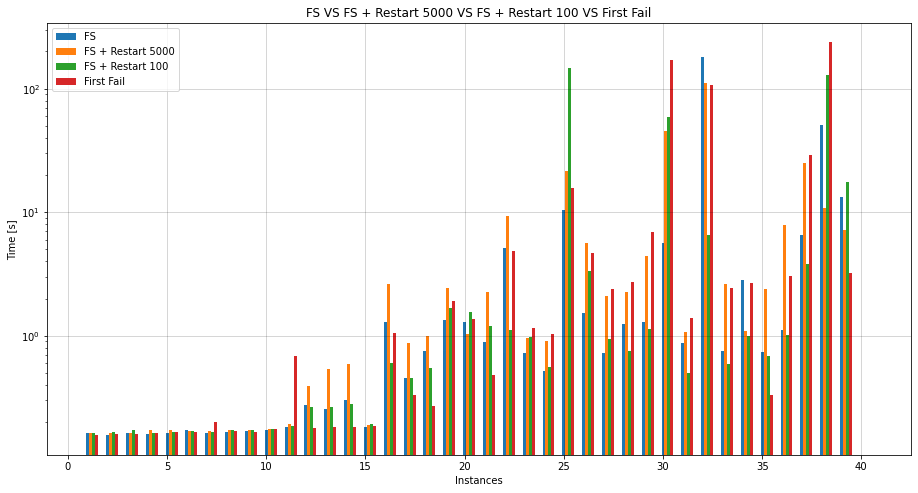

In [7]:
PlotStats({'FS':heuristics['time'], 
           'FS + Restart 5000':heuristics['time_restart5000'],
           'FS + Restart 100':heuristics['time_restart100'],
           'First Fail':heuristics['time_fail']},
            x_axis=list(models['Instance']), width_bar=0.15)

## Chuffed with/out Rotation

In [8]:
rotation = pd.read_csv('utils/datasets/chuffed_rotation.csv')
Statistics({'No Rotation':rotation['time_restart5000'], 
            'Rotation':rotation['time']}, 
           {'h_min':rotation['h_min'], 
            'No Rotation':rotation['h_restart5000'], 
            'Rotation':rotation['h']},
            timeout=300)

TIMEOUT is seen as 300s.

+------------------+-------------+----------+
|                  | No Rotation | Rotation |
+------------------+-------------+----------+
|  Total Time [s]  |     576.446 | 3725.503 |
|     Max [s]      |       300.0 |    300.0 |
|     Min [s]      |       0.163 |    0.163 |
|     Mean [s]     |      14.411 |   93.138 |
|     Std [s]      |      50.056 |  131.409 |
| Instances Solved |       39/40 |    29/40 |
|    Optimal H     |       39/40 |    29/40 |
+------------------+-------------+----------+


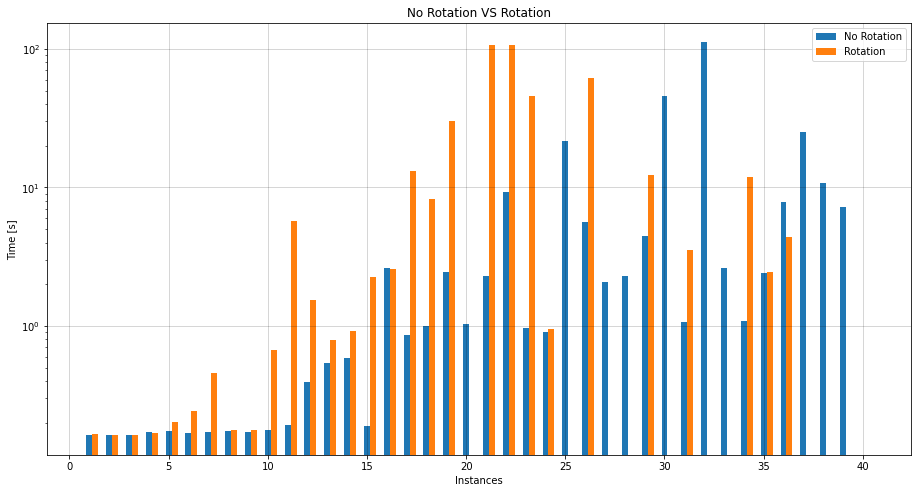

In [9]:
PlotStats({'No Rotation':rotation['time_restart5000'], 
           'Rotation':rotation['time']},
            x_axis=list(models['Instance']))